# Example of using the Borehole3D class

## Imports

In [1]:
from striplog import Component, Decor, Legend, Lexicon, Striplog
from core.visual import Borehole3D, striplog_legend_to_omf_legend 
from utils.lexicon.lexicon_memoris import lexicon_memoris, lithology_memoris, pollutants_memoris, CONTAMINATION_LEVELS_MEMORIS
from utils.utils import boreholes_from_dataframe
from utils.io import gdf_viewer
from core.project import Project
from core.orm import BoreholeOrm, PositionOrm, Base 
import random
from os import remove
import re
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker
from definitions import ROOT_DIR

## Reading of CSV files in a dir

In [2]:
#df = pd.read_csv('test_data_boreholes.csv', sep=',') # use english lexicon
df = pd.read_csv('test_litho_fr.csv', sep=',') # use french lexicon

In [3]:
all_pollutants = pollutants_memoris.pollutant
print(all_pollutants)

['arsenic', 'cadmium', 'chrome total', 'chrome vi', 'cobalt', 'cuivre', 'mercure', 'plomb', 'nickel', 'zinc', 'benzene', 'toluene', 'ethylbenzene', 'xylene sum', 'styrene', 'phenol', 'naphtalene', 'acenaphtylene', 'acenaphtene', 'fluorene', 'phenanthrene', 'anthracene', 'fluoranthene', 'pyrene', 'benzo(a)anthracene', 'chrysene', 'benzo(b)fluoranthene', 'benzo(k)fluoranthene', 'benzo(a)pyrene', 'dibenzo(ah)anthracene', 'benzo(ghi)perylene', 'indeno(1.2.3-cd)pyrene', '1.1-dichloroethane', '1.2-dichloroethane', 'cis 1.2 dichloroethene', 'trans 1.2 dichloroethene', 'dichloromethane', '1.2 dichloroethene sum', '1.2-dichloropropane', 'tetrachloroethene', 'tetrachloromethane', '1.1.1-trichloroethane', '1.1.2-trichloroethane', 'trichloroethene', 'trichloromethane (chloroforme)', 'chlorure de vinyle (chloroethene)', 'cyanures libres', 'methyl-tert-butyl-ether', 'fraction 5-8', 'fraction ec 8-10', 'fraction ec 10-12', 'fraction ec 12-16', 'fraction ec 16-21', 'fraction ec 21-35']


## Data Checking

In [4]:
#df[['Pollutant', 'Concentration']] = ''
df.drop(columns=['Pollutant', 'Concentration', 'Unit'], inplace=True)
#df['Concentration'] = df['Concentration'].apply(lambda x: np.random.randint(0,100))
#df['Unit'] = 'mg/l'

In [5]:
pol_lev = ['VR','VS','VI', 'Inconnu']
df[all_pollutants[0:2]] = ''
df[all_pollutants[0]] = df[all_pollutants[0]].apply(lambda x: random.sample(pol_lev, 1)[0])
df[all_pollutants[1]] = df[all_pollutants[1]].apply(lambda x: random.sample(pol_lev, 1)[0])

In [6]:
df['Lithology'] = df['Lithology'].replace({'Grès':'Marne', 'Calcaire':'Dolomie'})

In [7]:
df.loc[35.5, :] = ['BH007',152794.0, 121111.0, 60.0, 0.57, 45, 'Calcaire', 'Bleu', 4, 41, 45, 'VS', 'VR']
df.loc[25.5, :] = ['BH005',152473.0, 121460.0, 72.0, 0.61, 32, 'Schiste', 'gris', 3, 29, 32, 'VI', 'VR']
df.loc[25.6, :] = ['BH005',152473.0, 121460.0, 68.0, 0.61, 36, 'Calcaire', 'Bleu', 4, 32, 36, 'Inconnu', 'VR']

df.drop(index=4, inplace=True)
df.drop(columns='Colour', inplace=True)
df = df.sort_index().reset_index(drop=True)

In [8]:
pollutants = [p for p in all_pollutants if p in df.columns]

In [9]:
gdf_viewer(df)

Rows : 997, columns : 12


interactive(children=(IntSlider(value=10, description='rows', max=997, min=10, readout=False), IntSlider(value…

## Create Boreholes from dataframes or files

In [10]:
d = {'a':1, 'b':2, 'c':3, 'd':4}
list(d.keys()).index('d')

3

In [11]:
boreholes, components, link_intv_comp = boreholes_from_dataframe(df[:50], verbose=False,
                                                attributes=['Lithology']+pollutants, 
                                                symbols={'lithology':{'lexicon':lexicon_memoris}}, 
                                                diameter='Diameter', thickness='Thickness')


Dataframe processing...

|__ID:'BH001'
[Component({'lithology': 'sable'}), Component({'arsenic': 'vs'}), Component({'cadmium': 'vr'})]
[Component({'lithology': 'argile'}), Component({'arsenic': 'vr'}), Component({'cadmium': 'vr'})]
[Component({'lithology': 'marne'}), Component({'arsenic': 'vs'}), Component({'cadmium': 'vs'})]
[Component({'lithology': 'charbon'}), Component({'arsenic': 'vi'}), Component({'cadmium': 'inconnu'})]
Summary : [Striplog(4 Intervals, start=0.0, stop=28.0)]

|__ID:'BH002'
[Component({'lithology': 'sable'}), Component({'arsenic': 'vr'}), Component({'cadmium': 'vs'})]
[Component({'lithology': 'argile'}), Component({'arsenic': 'vs'}), Component({'cadmium': 'inconnu'})]
[Component({'lithology': 'marne'}), Component({'arsenic': 'vi'}), Component({'cadmium': 'vi'})]
[Component({'lithology': 'charbon'}), Component({'arsenic': 'vs'}), Component({'cadmium': 'vi'})]
[Component({'lithology': 'dolomie'}), Component({'arsenic': 'inconnu'}), Component({'cadmium': 'inconnu'}

/home/yanathan/Projects/GSDMA/utils/utils.py:255: SAWarning: relationship 'ComponentOrm.intervals' will copy column Components.id to column Linkintervalcomponent.comp_id, which conflicts with relationship(s): 'IntervalOrm.components' (copies Components.id to Linkintervalcomponent.comp_id). If this is not the intention, consider if these relationships should be linked with back_populates, or if viewonly=True should be applied to one or more if they are read-only. For the less common case that foreign key constraints are partially overlapping, the orm.foreign() annotation can be used to isolate the columns that should be written towards.   To silence this warning, add the parameter 'overlaps="components"' to the 'ComponentOrm.intervals' relationship.
  boreholes_orm.append(BoreholeOrm(id=bh_name))
/home/yanathan/Projects/GSDMA/utils/utils.py:255: SAWarning: relationship 'ComponentOrm.intervals' will copy column Intervals.id to column Linkintervalcomponent.int_id, which conflicts with rel

In [12]:
boreholes

[<core.orm.BoreholeOrm>(Name=BH001, Length=28.0, Diameter=0.43, Intervals=4),
 <core.orm.BoreholeOrm>(Name=BH002, Length=37.0, Diameter=0.6, Intervals=5),
 <core.orm.BoreholeOrm>(Name=BH003, Length=18.0, Diameter=0.41, Intervals=5),
 <core.orm.BoreholeOrm>(Name=BH004, Length=26.0, Diameter=0.61, Intervals=5),
 <core.orm.BoreholeOrm>(Name=BH005, Length=36.0, Diameter=0.61, Intervals=7),
 <core.orm.BoreholeOrm>(Name=BH006, Length=26.0, Diameter=0.31, Intervals=5),
 <core.orm.BoreholeOrm>(Name=BH007, Length=45.0, Diameter=0.57, Intervals=6),
 <core.orm.BoreholeOrm>(Name=BH008, Length=35.0, Diameter=0.39, Intervals=5),
 <core.orm.BoreholeOrm>(Name=BH009, Length=40.0, Diameter=0.5, Intervals=5),
 <core.orm.BoreholeOrm>(Name=BH10, Length=11.0, Diameter=0.31, Intervals=3)]

In [13]:
components

{0: Component({'lithology': 'sable'}),
 1: Component({'arsenic': 'vs'}),
 2: Component({'cadmium': 'vr'}),
 3: Component({'lithology': 'argile'}),
 4: Component({'arsenic': 'vr'}),
 5: Component({'lithology': 'marne'}),
 6: Component({'cadmium': 'vs'}),
 7: Component({'lithology': 'charbon'}),
 8: Component({'arsenic': 'vi'}),
 9: Component({'cadmium': 'inconnu'}),
 10: Component({'cadmium': 'vi'}),
 11: Component({'lithology': 'dolomie'}),
 12: Component({'arsenic': 'inconnu'}),
 13: Component({'lithology': 'schiste'}),
 14: Component({'lithology': 'calcaire'})}

In [14]:
link_intv_comp

{(0, 0): {'extra_data': ''},
 (0, 1): {'extra_data': ''},
 (0, 2): {'extra_data': ''},
 (1, 3): {'extra_data': ''},
 (1, 4): {'extra_data': ''},
 (1, 2): {'extra_data': ''},
 (2, 5): {'extra_data': ''},
 (2, 1): {'extra_data': ''},
 (2, 6): {'extra_data': ''},
 (3, 7): {'extra_data': ''},
 (3, 8): {'extra_data': ''},
 (3, 9): {'extra_data': ''},
 (4, 0): {'extra_data': ''},
 (4, 4): {'extra_data': ''},
 (4, 6): {'extra_data': ''},
 (5, 3): {'extra_data': ''},
 (5, 1): {'extra_data': ''},
 (5, 9): {'extra_data': ''},
 (6, 5): {'extra_data': ''},
 (6, 8): {'extra_data': ''},
 (6, 10): {'extra_data': ''},
 (7, 7): {'extra_data': ''},
 (7, 1): {'extra_data': ''},
 (7, 10): {'extra_data': ''},
 (8, 11): {'extra_data': ''},
 (8, 12): {'extra_data': ''},
 (8, 9): {'extra_data': ''},
 (9, 0): {'extra_data': ''},
 (9, 12): {'extra_data': ''},
 (9, 10): {'extra_data': ''},
 (10, 3): {'extra_data': ''},
 (10, 1): {'extra_data': ''},
 (10, 9): {'extra_data': ''},
 (11, 5): {'extra_data': ''},
 (11

In [15]:
len(boreholes), len(components)

(10, 15)

## Create a project and save data in a database

In [16]:
remove('tmp_files/tfe_orm_db.db')

In [17]:
engine = create_engine('sqlite:///tmp_files/tfe_orm_db.db', echo=True)

In [18]:
Base.metadata.create_all(engine)

2021-07-21 02:25:37,029 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2021-07-21 02:25:37,030 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("Boreholes")
2021-07-21 02:25:37,030 INFO sqlalchemy.engine.Engine [raw sql] ()
2021-07-21 02:25:37,032 INFO sqlalchemy.engine.Engine PRAGMA temp.table_info("Boreholes")
2021-07-21 02:25:37,032 INFO sqlalchemy.engine.Engine [raw sql] ()
2021-07-21 02:25:37,033 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("Intervals")
2021-07-21 02:25:37,034 INFO sqlalchemy.engine.Engine [raw sql] ()
2021-07-21 02:25:37,035 INFO sqlalchemy.engine.Engine PRAGMA temp.table_info("Intervals")
2021-07-21 02:25:37,035 INFO sqlalchemy.engine.Engine [raw sql] ()
2021-07-21 02:25:37,036 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("Components")
2021-07-21 02:25:37,037 INFO sqlalchemy.engine.Engine [raw sql] ()
2021-07-21 02:25:37,039 INFO sqlalchemy.engine.Engine PRAGMA temp.table_info("Components")
2021-07-21 02:25:37,039 INFO sqlalchemy.engine.Engin

In [19]:
Session = sessionmaker(bind=engine)
session = Session()

## Define project legend(s) and default attribute for representation

In [20]:
leg_dict = {**{'lithology':{'legend':lithology_memoris}},**{k:{'legend':None} for k in pollutants}}

In [21]:
p = Project(session, lexicon=lexicon_memoris, repr_attribute='lithology', legend_dict=leg_dict)

2021-07-21 02:25:37,105 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2021-07-21 02:25:37,109 INFO sqlalchemy.engine.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreholes_diameter" 
FROM "Boreholes"
2021-07-21 02:25:37,110 INFO sqlalchemy.engine.Engine [generated in 0.00118s] ()


In [22]:
p.legend_dict.keys()

dict_keys(['lithology', 'arsenic', 'cadmium'])

In [23]:
p.add_components(components)

2021-07-21 02:25:37,128 INFO sqlalchemy.engine.Engine INSERT INTO "Components" (id, description) VALUES (?, ?)
2021-07-21 02:25:37,130 INFO sqlalchemy.engine.Engine [generated in 0.00169s] ((0, 'Sable'), (1, 'Vs'), (2, 'Vr'), (3, 'Argile'), (4, 'Vr'), (5, 'Marne'), (6, 'Vs'), (7, 'Charbon')  ... displaying 10 of 15 total bound parameter sets ...  (13, 'Schiste'), (14, 'Calcaire'))
2021-07-21 02:25:37,132 INFO sqlalchemy.engine.Engine COMMIT
2021-07-21 02:25:37,136 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2021-07-21 02:25:37,137 INFO sqlalchemy.engine.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreholes_diameter" 
FROM "Boreholes"
2021-07-21 02:25:37,137 INFO sqlalchemy.engine.Engine [cached since 0.02867s ago] ()


In [24]:
p.__components__

{0: Component({'lithology': 'sable'}),
 1: Component({'arsenic': 'vs'}),
 2: Component({'cadmium': 'vr'}),
 3: Component({'lithology': 'argile'}),
 4: Component({'arsenic': 'vr'}),
 5: Component({'lithology': 'marne'}),
 6: Component({'cadmium': 'vs'}),
 7: Component({'lithology': 'charbon'}),
 8: Component({'arsenic': 'vi'}),
 9: Component({'cadmium': 'inconnu'}),
 10: Component({'cadmium': 'vi'}),
 11: Component({'lithology': 'dolomie'}),
 12: Component({'arsenic': 'inconnu'}),
 13: Component({'lithology': 'schiste'}),
 14: Component({'lithology': 'calcaire'})}

Add boreholes into the project

In [25]:
for bh in boreholes:
    p.add_borehole(bh)

2021-07-21 02:25:37,151 INFO sqlalchemy.engine.Engine INSERT INTO "Boreholes" (id, length, diameter) VALUES (?, ?, ?)
2021-07-21 02:25:37,153 INFO sqlalchemy.engine.Engine [generated in 0.00169s] ('BH001', 28.0, 0.43)
2021-07-21 02:25:37,155 INFO sqlalchemy.engine.Engine INSERT INTO "Positions" (id, upper, middle, lower, x, y) VALUES (?, ?, ?, ?, ?, ?)
2021-07-21 02:25:37,156 INFO sqlalchemy.engine.Engine [generated in 0.00083s] ((0, 101.0, 101.0, 101.0, 152600.0, 121039.0), (1, 97.0, 97.0, 97.0, 152600.0, 121039.0), (2, 97.0, 97.0, 97.0, 152600.0, 121039.0), (3, 93.0, 93.0, 93.0, 152600.0, 121039.0), (4, 93.0, 93.0, 93.0, 152600.0, 121039.0), (5, 81.0, 81.0, 81.0, 152600.0, 121039.0), (6, 81.0, 81.0, 81.0, 152600.0, 121039.0), (7, 73.0, 73.0, 73.0, 152600.0, 121039.0))
2021-07-21 02:25:37,158 INFO sqlalchemy.engine.Engine INSERT INTO "Intervals" (id, borehole, interval_number, description, top_id, base_id, data_id) VALUES (?, ?, ?, ?, ?, ?, ?)
2021-07-21 02:25:37,159 INFO sqlalchemy.e

2021-07-21 02:25:37,233 INFO sqlalchemy.engine.Engine [cached since 0.124s ago] ()
2021-07-21 02:25:37,235 INFO sqlalchemy.engine.Engine SELECT "Intervals".id AS "Intervals_id", "Intervals".borehole AS "Intervals_borehole", "Intervals".interval_number AS "Intervals_interval_number", "Intervals".description AS "Intervals_description", "Intervals".top_id AS "Intervals_top_id", "Intervals".base_id AS "Intervals_base_id", "Intervals".data_id AS "Intervals_data_id" 
FROM "Intervals" 
WHERE ? = "Intervals".borehole
2021-07-21 02:25:37,236 INFO sqlalchemy.engine.Engine [cached since 0.0659s ago] ('BH002',)
2021-07-21 02:25:37,238 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-07-21 02:25:37,239 INFO sqlalchemy.engine.Engine [cached since 0

2021-07-21 02:25:37,303 INFO sqlalchemy.engine.Engine [cached since 0.1279s ago] (18,)
2021-07-21 02:25:37,305 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-07-21 02:25:37,306 INFO sqlalchemy.engine.Engine [cached since 0.1256s ago] (19,)
2021-07-21 02:25:37,307 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-07-21 02:25:37,308 INFO sqlalchemy.engine.Engine [cached since 0.1326s ago] (20,)
2021-07-21 02:25:37,310 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_i

2021-07-21 02:25:37,376 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-07-21 02:25:37,376 INFO sqlalchemy.engine.Engine [cached since 0.1961s ago] (31,)
2021-07-21 02:25:37,378 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-07-21 02:25:37,379 INFO sqlalchemy.engine.Engine [cached since 0.2039s ago] (32,)
2021-07-21 02:25:37,381 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "

2021-07-21 02:25:37,444 INFO sqlalchemy.engine.Engine [cached since 0.2683s ago] (42,)
2021-07-21 02:25:37,446 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-07-21 02:25:37,447 INFO sqlalchemy.engine.Engine [cached since 0.2666s ago] (43,)
2021-07-21 02:25:37,449 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-07-21 02:25:37,450 INFO sqlalchemy.engine.Engine [cached since 0.2743s ago] (44,)
2021-07-21 02:25:37,452 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_i

2021-07-21 02:25:37,515 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-07-21 02:25:37,516 INFO sqlalchemy.engine.Engine [cached since 0.3359s ago] (55,)
2021-07-21 02:25:37,518 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-07-21 02:25:37,519 INFO sqlalchemy.engine.Engine [cached since 0.344s ago] (56,)
2021-07-21 02:25:37,522 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "P

2021-07-21 02:25:37,584 INFO sqlalchemy.engine.Engine [cached since 0.409s ago] (66,)
2021-07-21 02:25:37,586 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-07-21 02:25:37,587 INFO sqlalchemy.engine.Engine [cached since 0.4069s ago] (67,)
2021-07-21 02:25:37,589 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-07-21 02:25:37,590 INFO sqlalchemy.engine.Engine [cached since 0.4149s ago] (68,)
2021-07-21 02:25:37,592 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id

2021-07-21 02:25:37,661 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-07-21 02:25:37,662 INFO sqlalchemy.engine.Engine [cached since 0.4819s ago] (79,)
2021-07-21 02:25:37,664 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-07-21 02:25:37,665 INFO sqlalchemy.engine.Engine [cached since 0.4895s ago] (80,)
2021-07-21 02:25:37,667 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "

2021-07-21 02:25:37,729 INFO sqlalchemy.engine.Engine [cached since 0.5484s ago] (91,)
2021-07-21 02:25:37,730 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-07-21 02:25:37,731 INFO sqlalchemy.engine.Engine [cached since 0.5557s ago] (92,)
2021-07-21 02:25:37,733 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-07-21 02:25:37,734 INFO sqlalchemy.engine.Engine [cached since 0.5537s ago] (93,)

*_*_*_*_ {'top': Position({'middle': 100.0, 'x': 152052.0, 'y': 121293.0, 'units': 'm'}), 

In [26]:
p.boreholes_3d[0].name, p.boreholes_3d[0].components

('BH001',
 {0: [Component({'lithology': 'sable'}),
   Component({'arsenic': 'vs'}),
   Component({'cadmium': 'vr'})],
  1: [Component({'lithology': 'argile'}),
   Component({'arsenic': 'vr'}),
   Component({'cadmium': 'vr'})],
  2: [Component({'lithology': 'marne'}),
   Component({'arsenic': 'vs'}),
   Component({'cadmium': 'vs'})],
  3: [Component({'lithology': 'charbon'}),
   Component({'arsenic': 'vi'}),
   Component({'cadmium': 'inconnu'})]})

In [27]:
p.boreholes_orm

2021-07-21 02:25:37,820 INFO sqlalchemy.engine.Engine UPDATE "Boreholes" SET length=? WHERE "Boreholes".id = ?
2021-07-21 02:25:37,822 INFO sqlalchemy.engine.Engine [cached since 0.6054s ago] (95.0, 'BH10')
2021-07-21 02:25:37,824 INFO sqlalchemy.engine.Engine SELECT "Intervals".id AS "Intervals_id", "Intervals".borehole AS "Intervals_borehole", "Intervals".interval_number AS "Intervals_interval_number", "Intervals".description AS "Intervals_description", "Intervals".top_id AS "Intervals_top_id", "Intervals".base_id AS "Intervals_base_id", "Intervals".data_id AS "Intervals_data_id" 
FROM "Intervals" 
WHERE ? = "Intervals".borehole
2021-07-21 02:25:37,825 INFO sqlalchemy.engine.Engine [cached since 0.6549s ago] ('BH001',)
2021-07-21 02:25:37,827 INFO sqlalchemy.engine.Engine SELECT "Intervals".id AS "Intervals_id", "Intervals".borehole AS "Intervals_borehole", "Intervals".interval_number AS "Intervals_interval_number", "Intervals".description AS "Intervals_description", "Intervals".top_

[<core.orm.BoreholeOrm>(Name=BH001, Length=97.0, Diameter=0.43, Intervals=4),
 <core.orm.BoreholeOrm>(Name=BH002, Length=98.0, Diameter=0.6, Intervals=5),
 <core.orm.BoreholeOrm>(Name=BH003, Length=100.0, Diameter=0.41, Intervals=5),
 <core.orm.BoreholeOrm>(Name=BH004, Length=96.0, Diameter=0.61, Intervals=5),
 <core.orm.BoreholeOrm>(Name=BH005, Length=97.0, Diameter=0.61, Intervals=7),
 <core.orm.BoreholeOrm>(Name=BH006, Length=100.0, Diameter=0.31, Intervals=5),
 <core.orm.BoreholeOrm>(Name=BH007, Length=97.0, Diameter=0.57, Intervals=6),
 <core.orm.BoreholeOrm>(Name=BH008, Length=98.0, Diameter=0.39, Intervals=5),
 <core.orm.BoreholeOrm>(Name=BH009, Length=94.0, Diameter=0.5, Intervals=5),
 <core.orm.BoreholeOrm>(Name=BH10, Length=95.0, Diameter=0.31, Intervals=3)]

In [28]:
p.add_link_between_components_and_intervals(link_intv_comp)

2021-07-21 02:25:37,868 INFO sqlalchemy.engine.Engine INSERT INTO "Linkintervalcomponent" (int_id, comp_id, extra_data) VALUES (?, ?, ?)
2021-07-21 02:25:37,870 INFO sqlalchemy.engine.Engine [generated in 0.00228s] ((0, 0, ''), (0, 1, ''), (0, 2, ''), (1, 3, ''), (1, 4, ''), (1, 2, ''), (2, 5, ''), (2, 1, '')  ... displaying 10 of 150 total bound parameter sets ...  (49, 8, ''), (49, 10, ''))
2021-07-21 02:25:37,874 INFO sqlalchemy.engine.Engine COMMIT
2021-07-21 02:25:37,879 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2021-07-21 02:25:37,880 INFO sqlalchemy.engine.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreholes_diameter" 
FROM "Boreholes"
2021-07-21 02:25:37,881 INFO sqlalchemy.engine.Engine [cached since 0.7724s ago] ()


In [29]:
p.commit()
print('Boreholes in the project : ', len(p.boreholes_orm))

2021-07-21 02:25:37,887 INFO sqlalchemy.engine.Engine COMMIT
Boreholes in the project :  10


In [30]:
p.boreholes_orm[2].intervals

2021-07-21 02:25:37,895 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2021-07-21 02:25:37,898 INFO sqlalchemy.engine.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreholes_diameter" 
FROM "Boreholes" 
WHERE "Boreholes".id = ?
2021-07-21 02:25:37,899 INFO sqlalchemy.engine.Engine [generated in 0.00100s] ('BH003',)
2021-07-21 02:25:37,900 INFO sqlalchemy.engine.Engine SELECT "Intervals".id AS "Intervals_id", "Intervals".borehole AS "Intervals_borehole", "Intervals".interval_number AS "Intervals_interval_number", "Intervals".description AS "Intervals_description", "Intervals".top_id AS "Intervals_top_id", "Intervals".base_id AS "Intervals_base_id", "Intervals".data_id AS "Intervals_data_id" 
FROM "Intervals" 
WHERE ? = "Intervals".borehole
2021-07-21 02:25:37,901 INFO sqlalchemy.engine.Engine [cached since 0.7312s ago] ('BH003',)
2021-07-21 02:25:37,904 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_

{9: <core.orm.IntervalOrm>(Id=9, Borehole=BH003, top=<core.orm.PositionOrm object at 0x7f8cfe8b48b0>Description={"lithology": "sable"}, {"arsenic": "inconnu"}, {"cadmium": "vi"}, Components=[<core.orm.ComponentOrm>(Id=0, Description=Sable), <core.orm.ComponentOrm>(Id=10, Description=Vi), <core.orm.ComponentOrm>(Id=12, Description=Inconnu)]),
 10: <core.orm.IntervalOrm>(Id=10, Borehole=BH003, top=<core.orm.PositionOrm object at 0x7f8cfe83ae80>Description={"lithology": "argile"}, {"arsenic": "vs"}, {"cadmium": "inconnu"}, Components=[<core.orm.ComponentOrm>(Id=1, Description=Vs), <core.orm.ComponentOrm>(Id=3, Description=Argile), <core.orm.ComponentOrm>(Id=9, Description=Inconnu)]),
 11: <core.orm.IntervalOrm>(Id=11, Borehole=BH003, top=<core.orm.PositionOrm object at 0x7f8cfe8b4ee0>Description={"lithology": "marne"}, {"arsenic": "vs"}, {"cadmium": "vi"}, Components=[<core.orm.ComponentOrm>(Id=1, Description=Vs), <core.orm.ComponentOrm>(Id=5, Description=Marne), <core.orm.ComponentOrm>(I

In [31]:
p.refresh(verbose=False)

2021-07-21 02:25:37,937 INFO sqlalchemy.engine.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreholes_diameter" 
FROM "Boreholes"
2021-07-21 02:25:37,939 INFO sqlalchemy.engine.Engine [cached since 0.8307s ago] ()


In [32]:
eval(Component({'lithology':'sable'}).json())

{'lithology': 'sable'}

# 2D/3D Display

In [33]:
attributes = list(p.legend_dict.keys())
attributes

['lithology', 'arsenic', 'cadmium']

In [34]:
p.update_legend_cmap(update_all_attrib=True)

({'lithology': {'legend': Legend(Decor({'_colour': '#ffcb23', 'width': 3, 'hatch': "'..'", 'component': Component({'lithology': 'sable'})})
   Decor({'_colour': '#d5e6cc', 'width': 3, 'hatch': "'---'", 'component': Component({'lithology': 'argile'})})
   Decor({'_colour': '#7ba1a8', 'width': 3, 'hatch': None, 'component': Component({'lithology': 'marne'})})
   Decor({'_colour': '#000000', 'width': 3, 'hatch': None, 'component': Component({'lithology': 'charbon'})})
   Decor({'_colour': '#fdaffe', 'width': 3, 'hatch': None, 'component': Component({'lithology': 'dolomie'})})
   Decor({'_colour': '#bbffdd', 'width': 3, 'hatch': "'--'", 'component': Component({'lithology': 'schiste'})})
   Decor({'_colour': '#149eff', 'width': 3, 'hatch': "'='", 'component': Component({'lithology': 'calcaire'})})),
   'cmap': <matplotlib.colors.ListedColormap at 0x7f8cfe8575e0>,
   'values': ['sable',
    'argile',
    'marne',
    'charbon',
    'dolomie',
    'schiste',
    'calcaire']},
  'arsenic': {'l

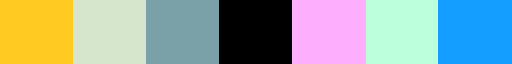

In [35]:
p.legend_dict[attributes[0]]['cmap']

In [36]:
p.legend_dict[attributes[0]]['values']

['sable', 'argile', 'marne', 'charbon', 'dolomie', 'schiste', 'calcaire']

## Display one object (attribute = 'lithology')

In [37]:
bh = 6
p.boreholes_3d[bh].components

{0: [Component({'lithology': 'sable'}),
  Component({'arsenic': 'vr'}),
  Component({'cadmium': 'vr'})],
 1: [Component({'lithology': 'argile'}),
  Component({'arsenic': 'vr'}),
  Component({'cadmium': 'vi'})],
 2: [Component({'lithology': 'marne'}),
  Component({'arsenic': 'vs'}),
  Component({'cadmium': 'vr'})],
 3: [Component({'lithology': 'charbon'}),
  Component({'arsenic': 'vr'}),
  Component({'cadmium': 'vr'})],
 4: [Component({'lithology': 'dolomie'}),
  Component({'arsenic': 'vi'}),
  Component({'cadmium': 'inconnu'})],
 5: [Component({'lithology': 'calcaire'}),
  Component({'arsenic': 'vs'}),
  Component({'cadmium': 'vr'})]}

/home/yanathan/Projects/GSDMA/utils/visual.py:421: MatplotlibDeprecationWarning: hatch must consist of a string of "*+-./OX\ox|" or None, but found the following invalid values "'". Passing invalid values is deprecated since 3.4 and will become an error two minor releases later.
  rect = mpl.patches.Rectangle(origin, w, thick, fc=fc, lw=lw, hatch=d.hatch,
/home/yanathan/Projects/GSDMA/utils/visual.py:421: MatplotlibDeprecationWarning: hatch must consist of a string of "*+-./OX\ox|" or None, but found the following invalid values "'=". Passing invalid values is deprecated since 3.4 and will become an error two minor releases later.
  rect = mpl.patches.Rectangle(origin, w, thick, fc=fc, lw=lw, hatch=d.hatch,
/home/yanathan/.local/share/virtualenvs/GSDMA-DRfwm83x/lib/python3.8/site-packages/striplog/legend.py:311: MatplotlibDeprecationWarning: hatch must consist of a string of "*+-./OX\ox|" or None, but found the following invalid values "'=". Passing invalid values is deprecated since 3

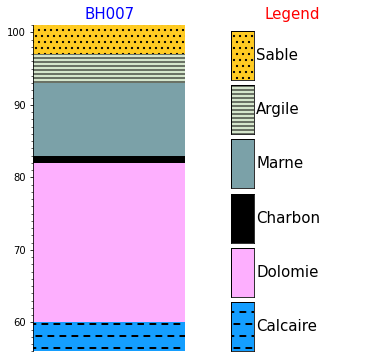

In [38]:
p.boreholes_3d[bh].log_plot()

In [39]:
sargs = dict(title='Test_legend', title_font_size=30, label_font_size=12, n_labels=0,
             fmt="%.2f", font_family="arial", color='k',interactive=True, 
             vertical=True, italic=True, shadow=False,)

In [40]:
p.boreholes_3d[bh].plot3d(custom_legend=False, scalar_bar_args=sargs)

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

In [41]:
p.plot2d()

## Plot with another attribute

/home/yanathan/Projects/GSDMA/utils/visual.py:421: MatplotlibDeprecationWarning: hatch must consist of a string of "*+-./OX\ox|" or None, but found the following invalid values "'". Passing invalid values is deprecated since 3.4 and will become an error two minor releases later.
  rect = mpl.patches.Rectangle(origin, w, thick, fc=fc, lw=lw, hatch=d.hatch,
/home/yanathan/Projects/GSDMA/utils/visual.py:421: MatplotlibDeprecationWarning: hatch must consist of a string of "*+-./OX\ox|" or None, but found the following invalid values "'=". Passing invalid values is deprecated since 3.4 and will become an error two minor releases later.
  rect = mpl.patches.Rectangle(origin, w, thick, fc=fc, lw=lw, hatch=d.hatch,
/home/yanathan/.local/share/virtualenvs/GSDMA-DRfwm83x/lib/python3.8/site-packages/striplog/legend.py:311: MatplotlibDeprecationWarning: hatch must consist of a string of "*+-./OX\ox|" or None, but found the following invalid values "'=". Passing invalid values is deprecated since 3

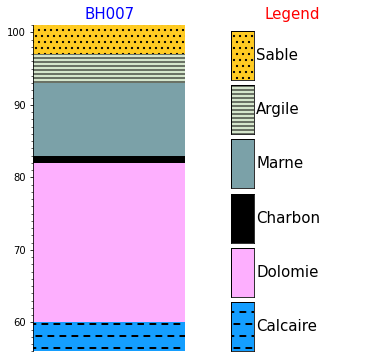

In [42]:
at = 0
p.boreholes_3d[bh].log_plot(repr_attribute=attributes[at])

In [43]:
p.boreholes_3d[bh].plot3d(repr_attribute=attributes[at])

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

### Display project boreholes

In [44]:
bh3d_vtk = p.boreholes_3d[bh]._vtk
bh3d_vtk

PolyData (0x7f8cfe91f160)
  N Cells:	312
  N Points:	1200
  X Bounds:	1.528e+05, 1.528e+05
  Y Bounds:	1.211e+05, 1.211e+05
  Z Bounds:	5.600e+01, 1.010e+02
  N Arrays:	6

In [ ]:
at = 0
prj_mapper = p.plot3d(repr_attribute=attributes[at],  bg_color=["royalblue", "aliceblue"], 
                      window_size=(800, 500))

### Boreholes in 3D using X3D for interaction within the notebook